### Introduction:
This project focuses on price prediction for Amazon products across categories such as Automotive, Electronics, and Office Products. We employed large language models to analyze textual descriptions and fine-tuned our models using Weights & Biases (W&B) to predict commodity prices.

In [ ]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle
import re
import json
import openai
from items import Item
from openai import OpenAI
from testing import Tester
%matplotlib inline

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
# Environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

# Log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)
print(f"Number of Appliances: {len(dataset):,}")
print(dataset.shape)

Number of Appliances: 94,327
(94327, 16)


In [4]:
a = dataset.to_pandas()
a[['title', "description","features", "price", "details"]].head(5)

,title,description,features,price,details
0,"ROVSUN Ice Maker Machine Countertop, Make 44lb...",[],[【Quick Ice Making】This countertop ice machine...,None,"{""Brand"": ""ROVSUN"", ""Model Name"": ""ICM-2005"", ..."
1,"HANSGO Egg Holder for Refrigerator, Deviled Eg...",[],"[Plastic, Practical Kitchen Storage - Our egg ...",None,"{""Manufacturer"": ""HANSGO"", ""Part Number"": ""HAN..."
2,"Clothes Dryer Drum Slide, General Electric, Ho...","[Brand new dryer drum slide, replaces General ...",[],None,"{""Manufacturer"": ""RPI"", ""Part Number"": ""WE1M33..."
3,154567702 Dishwasher Lower Wash Arm Assembly f...,[MODEL NUMBER:154567702 Dishwasher Lower Wash ...,[MODEL NUMBER:154567702 Dishwasher Lower Wash ...,None,"{""Manufacturer"": ""folosem"", ""Part Number"": ""15..."
4,Whirlpool W10918546 Igniter,[Whirlpool Igniter],[This is a Genuine OEM Replacement Part.],25.07,"{""Manufacturer"": ""Whirlpool"", ""Part Number"": ""..."


In [5]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [6]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

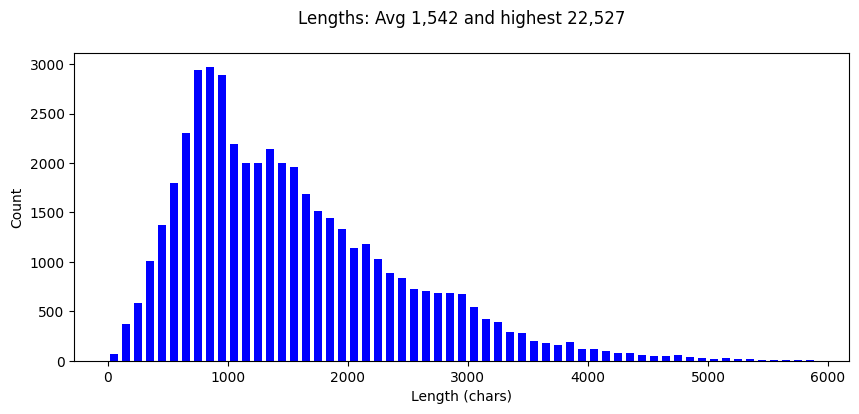

In [7]:
# Plot the distribution of lengths

plt.figure(figsize=(10, 4))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="blue", bins=range(0, 6000, 100))
plt.show()

In [8]:
# Load in the same dataset as above
items = ItemLoader("Appliances").load()
items[4]

Loading dataset Appliances


100%|██████████| 95/95 [00:22<00:00,  4.22it/s]


Completed Appliances with 27,500 datapoints in 0.4 mins


<Homa Yellow Flower Bouquet Floral Dishwasher Magnet，Green Border Accent with Lemons Sticker Refrigerator Magnetic Cover Panel Decal 23 W x 17 H = $34.99>

In [9]:
# Sample
print(items[1].prompt)

How much does this cost to the nearest dollar?

door pivot block - compatible kenmore kitchenaid maytag whirlpool refrigerator - replaces - quick diy repair solution pivot block for vernicle mullion strip on door - a high - quality exact equivalent for part numbers and compatibility with major brands - door guide is compatible with whirlpool, amana, dacor, gaggenau, hardwick, jenn - air, kenmore, kitchenaid, and maytag. quick diy repair - refrigerator door guide pivot block replacement will help if your appliance door doesn ' t open or close. wear work gloves to protect your hands during the repair process. attentive support - if you are uncertain about whether the block fits your refrigerator, we will help. we generally put forth a valiant effort to

Price is $17.00


In [10]:
# Extract 3 type due to expensive computation
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products"]

In [11]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

print(f"A grand total of {len(items):,} items")

Loading dataset Automotive


100%|██████████| 2004/2004 [11:20<00:00,  2.95it/s]


Completed Automotive with 870,795 datapoints in 11.6 mins
Loading dataset Electronics


100%|██████████| 1611/1611 [06:56<00:00,  3.87it/s]


Completed Electronics with 431,703 datapoints in 7.1 mins
Loading dataset Office_Products


100%|██████████| 711/711 [02:44<00:00,  4.33it/s]


Completed Office_Products with 231,387 datapoints in 2.8 mins
A grand total of 1,533,885 items


In [12]:
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)


np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 344,763 items in the sample


In [13]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

# Test
report(sample[8])

How much does this cost to the nearest dollar?

beck / arnley thermostat gasket beck / arnley parts meet foreign nameplate oe specifications for form, fit and function. our product specialists work with a network of global sourcing partners so you can install the right part with confidence. matches oe form, fit, and function high quality rubber or composite material designed to withstand high heat conditions quality construction for durability packaged in clear plastic for easy visibility and identification of all components application specific to ensure a correct fit for your vehicle manufacturer beck / arnley, brand beck / arnley, weight 0. 32 ounces, dimensions 4 x 1 x 6 inches, model number manufacturer part rank automotive automotive replacement engine thermostats 5256, available november 11, 2005

Price is $1.00
[2340, 1010, 2384, 3976, 2003, 1002, 1015, 1012, 4002, 102]
['11', ',', '2005', 'price', 'is', '$', '1', '.', '00', '[SEP]']


In [14]:
# Train and test
random.seed(42)
random.shuffle(sample)
train = sample[:400_00]
test = sample[400_00:402_00]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")
print(train[1].prompt)
print(test[1].test_prompt())

Divided into a training set of 40,000 items and test set of 200 items
How much does this cost to the nearest dollar?

gm genuine parts engine cooling fan clutch acdelco gm original equipment engine cooling fan clutches control the speed of the radiator fan based on the temperature of the air after it passes through the radiator fins. this original equipment engine cooling fan clutch is a gm - recommended replacement for your vehicle ’ s original components and has been manufactured to fit your gm vehicle, providing the same performance, durability, and service life you expect from general motors. quiets noisy cooling fans with stuck fan clutches, restores fuel economy gm - recommended replacement part for your gm vehicle ’ s original factory component offering the quality, reliability, and durability of gm oe manufactured to gm oe specification for fit, form, and function manufacturer acdelco, brand general motors, model clutch asm,

Price is $212.00
How much does this cost to the near

In [15]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [ ]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Save
# with open('train.pkl', 'wb') as file:
#     pickle.dump(train, file)

# with open('test.pkl', 'wb') as file:
#     pickle.dump(test, file)

# # Load
# with open('train.pkl', 'rb') as file:
#     train = pickle.load(file)

# with open('test.pkl', 'rb') as file:
#     test = pickle.load(file)

In [81]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:200]:
        writer.writerow([t.test_prompt(), 0])

In [18]:
human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))
len(human_predictions)

250

In [19]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]


def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

# test
messages_for(test[2])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\n80 + flipped culture lessons for the spanish classroom our 80 + flipped culture lessons for spanish book helps teachers introduce students to spanish culture using lessons as out - of - class assignments or as in - class computer activities. these lessons are excellent tools for students to experience the spanish worldview. “ flipping ” is when the teacher no longer lectures but uses class time to work with the students. teachers use their time to interact with students and do more guided learning. flipping the classroom gives students a greater knowledge of spanish culture than ever before, as teachers will have additional time to teach vocabulary and grammar through in - class assignments. this book contains worksheets for the students to complete and bring to class for discussions. book contains a printable cd. ©2014

In [20]:
import re as re
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

get_price("The price is roughly $99.99 because blah blah")

99.99

In [21]:
# Function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $100.00 Truth: $286.39 Error: $186.39 SLE: 1.09 Item: Power Stop AR83078XPR Front Evolution Dr...
2: Guess: $15.99 Truth: $1.99 Error: $14.00 SLE: 3.02 Item: RegulatorFix Window Regulator Repair Cli...
3: Guess: $35.00 Truth: $45.99 Error: $10.99 SLE: 0.07 Item: 80+ Flipped Culture Lessons for the Span...
4: Guess: $100.00 Truth: $175.00 Error: $75.00 SLE: 0.31 Item: APC UPS BE850M2, 850VA UPS Battery Backu...
5: Guess: $150.00 Truth: $99.99 Error: $50.01 SLE: 0.16 Item: LG 24MK430H-B 24in Class (23.8in) IPS LE...
6: Guess: $149.99 Truth: $194.95 Error: $44.96 SLE: 0.07 Item: 22-Inch Neon LED TV by Continu.us | Colo...
7: Guess: $150.00 Truth: $84.00 Error: $66.00 SLE: 0.33 Item: NVIDIA Quadro K4000 3GB GDDR5 256-bit PC...
8: Guess: $85.99 Truth: $64.99 Error: $21.00 SLE: 0.08 Item: TCMT Black Front Headlight Head Light La...
9: Guess: $199.99 Truth: $305.15 Error: $105.16 SLE: 0.18 Item: PIAA 12-07210 RF Series Yellow 10" SAE C...
10: Guess: $119.99 Truth: $159.99 Error: $40

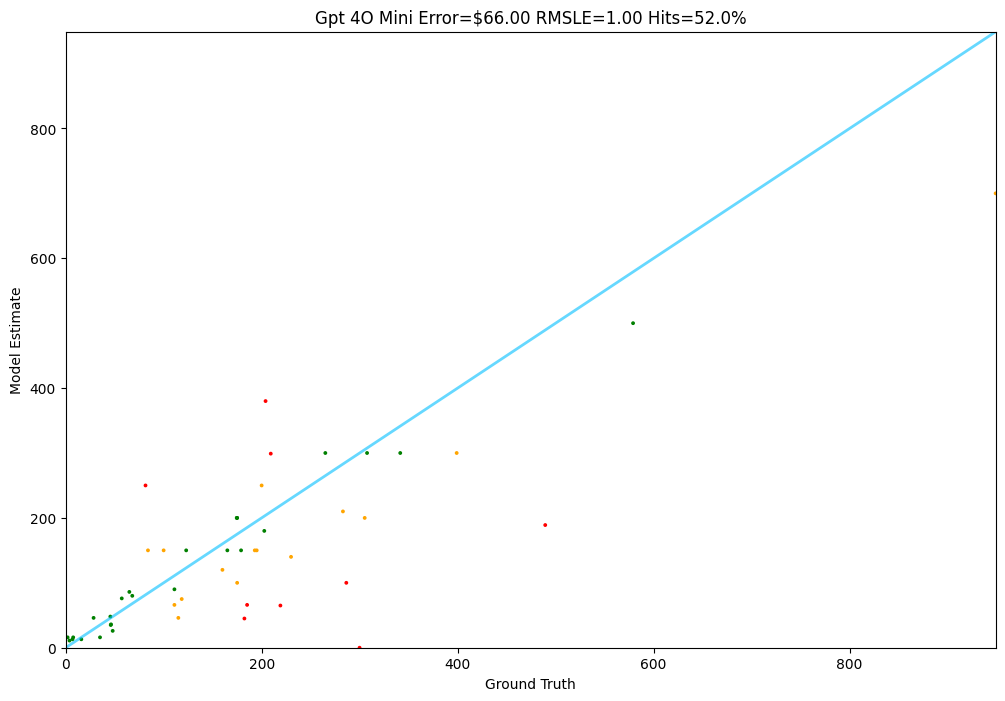

In [57]:

Tester(gpt_4o_mini, data=test[:50], size=50).run()

1: Guess: $100.00 Truth: $286.39 Error: $186.39 SLE: 1.09 Item: Power Stop AR83078XPR Front Evolution Dr...
2: Guess: $30.00 Truth: $1.99 Error: $28.01 SLE: 5.47 Item: RegulatorFix Window Regulator Repair Cli...
3: Guess: $39.95 Truth: $45.99 Error: $6.04 SLE: 0.02 Item: 80+ Flipped Culture Lessons for the Span...
4: Guess: $120.00 Truth: $175.00 Error: $55.00 SLE: 0.14 Item: APC UPS BE850M2, 850VA UPS Battery Backu...
5: Guess: $109.99 Truth: $99.99 Error: $10.00 SLE: 0.01 Item: LG 24MK430H-B 24in Class (23.8in) IPS LE...
6: Guess: $150.00 Truth: $194.95 Error: $44.95 SLE: 0.07 Item: 22-Inch Neon LED TV by Continu.us | Colo...
7: Guess: $150.00 Truth: $84.00 Error: $66.00 SLE: 0.33 Item: NVIDIA Quadro K4000 3GB GDDR5 256-bit PC...
8: Guess: $100.00 Truth: $64.99 Error: $35.01 SLE: 0.18 Item: TCMT Black Front Headlight Head Light La...
9: Guess: $250.00 Truth: $305.15 Error: $55.15 SLE: 0.04 Item: PIAA 12-07210 RF Series Yellow 10" SAE C...
10: Guess: $180.00 Truth: $159.99 Error: $20.

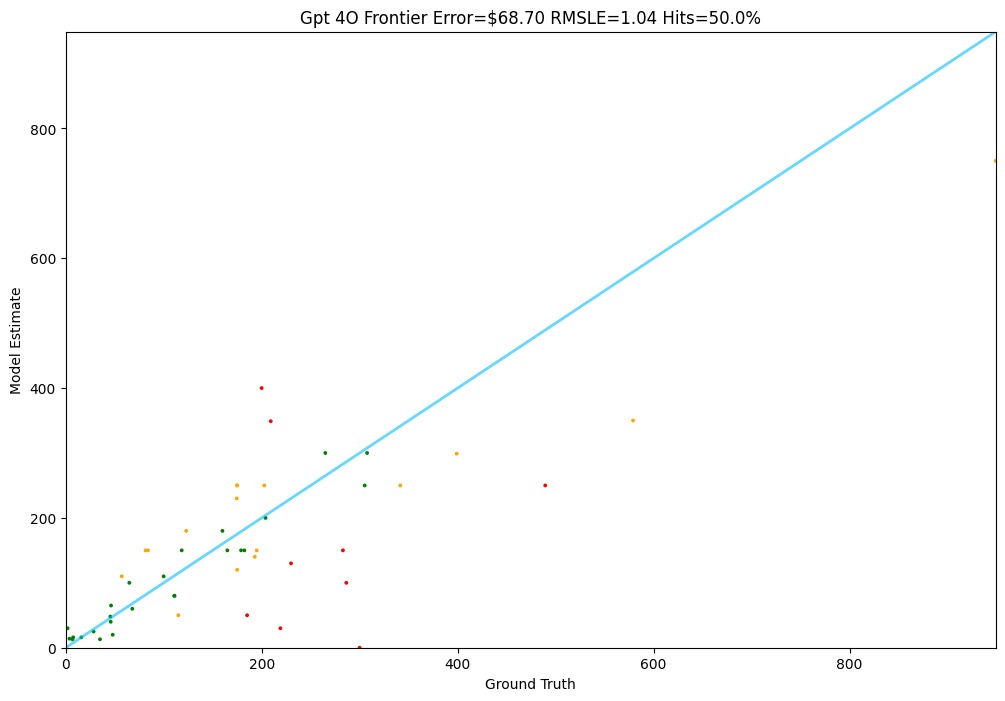

In [58]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

Tester(gpt_4o_frontier, data=test[:50], size=50).run()

### Fine tune

In [60]:
fine_tune_train = train[:500]
fine_tune_validation = train[500:550]


def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()


def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [62]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

train_file

FileObject(id='file-JdbJTwd8o4v1JxUnLvqGtU', bytes=491132, created_at=1743513201, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [64]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

validation_file

FileObject(id='file-1DY8jbHer9QQxs4KgpAzGT', bytes=47779, created_at=1743513250, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

### Fine tune with Wandb.ai

In [65]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-3KQKjN9y1C70p59RjMqQDnRf', created_at=1743513260, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-aGAYhFScz4SWl6BTfNw89XY7', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-JdbJTwd8o4v1JxUnLvqGtU', validation_file='file-1DY8jbHer9QQxs4KgpAzGT', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-3KQKjN9y1C70p59RjMqQDnRf'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [66]:
openai.fine_tuning.jobs.list(limit=1)

job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id
print(job_id)

openai.fine_tuning.jobs.retrieve(job_id)
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

ftjob-3KQKjN9y1C70p59RjMqQDnRf


[FineTuningJobEvent(id='ftevent-lIdQzbRfzaNRxpylrw8YBv3r', created_at=1743513260, level='info', message='Validating training file: file-JdbJTwd8o4v1JxUnLvqGtU and validation file: file-1DY8jbHer9QQxs4KgpAzGT', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-jeX27iLMhS7eJrDOfsCGvYVR', created_at=1743513260, level='info', message='Created fine-tuning job: ftjob-3KQKjN9y1C70p59RjMqQDnRf', object='fine_tuning.job.event', data={}, type='message')]

In [85]:
job = openai.fine_tuning.jobs.retrieve(job_id)
print(job.status)
print(job)

succeeded
FineTuningJob(id='ftjob-3KQKjN9y1C70p59RjMqQDnRf', created_at=1743513260, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal:pricer:BHW8Z0ZB', finished_at=1743514810, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-aGAYhFScz4SWl6BTfNw89XY7', result_files=['file-BqZj2LMACVQnhvLktzy5rp'], seed=42, status='succeeded', trained_tokens=102097, training_file='file-JdbJTwd8o4v1JxUnLvqGtU', validation_file='file-1DY8jbHer9QQxs4KgpAzGT', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-3KQKjN9y1C70p59RjMqQDnRf'))], metadata=None, method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_e

In [86]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:BHW8Z0ZB'

In [87]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [88]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\npower stop front evolution drilled & slotted rotor pair power stop drilled and slotted rotors give you the advantages of both drilled holes for cooling and slots to sweep away gas and dust. power stop rotors use only the finest blanks and feature g3000 grade castings from the best foundries. all drilled and slotted rotors ( except for hub rotor assemblies ) are silver zinc plated to resist rust. the drilled and slotted design is our most popular performance rotor for street and day track applications. drill holes keep brake rotors up to 180 degrees cooler slots keep a clear contact patch between the pad and the rotor increased braking performance look great behind custom ( or factory ) wheels manufacturer power stop, brand power stop, model power stop weight 55. 7 pounds, dimensions 15. 4 x'},
 {'role': 'assistant', 'co

In [89]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

get_price("The price is roughly $99.99 because blah blah")

99.99

In [90]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [91]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

286.39
289.99


1: Guess: $289.99 Truth: $286.39 Error: $3.60 SLE: 0.00 Item: Power Stop AR83078XPR Front Evolution Dr...
2: Guess: $14.65 Truth: $1.99 Error: $12.66 SLE: 2.74 Item: RegulatorFix Window Regulator Repair Cli...
3: Guess: $49.00 Truth: $45.99 Error: $3.01 SLE: 0.00 Item: 80+ Flipped Culture Lessons for the Span...
4: Guess: $179.99 Truth: $175.00 Error: $4.99 SLE: 0.00 Item: APC UPS BE850M2, 850VA UPS Battery Backu...
5: Guess: $126.99 Truth: $99.99 Error: $27.00 SLE: 0.06 Item: LG 24MK430H-B 24in Class (23.8in) IPS LE...
6: Guess: $367.99 Truth: $194.95 Error: $173.04 SLE: 0.40 Item: 22-Inch Neon LED TV by Continu.us | Colo...
7: Guess: $817.29 Truth: $84.00 Error: $733.29 SLE: 5.13 Item: NVIDIA Quadro K4000 3GB GDDR5 256-bit PC...
8: Guess: $193.95 Truth: $64.99 Error: $128.96 SLE: 1.17 Item: TCMT Black Front Headlight Head Light La...
9: Guess: $127.22 Truth: $305.15 Error: $177.93 SLE: 0.76 Item: PIAA 12-07210 RF Series Yellow 10" SAE C...
10: Guess: $289.99 Truth: $159.99 Error: $13

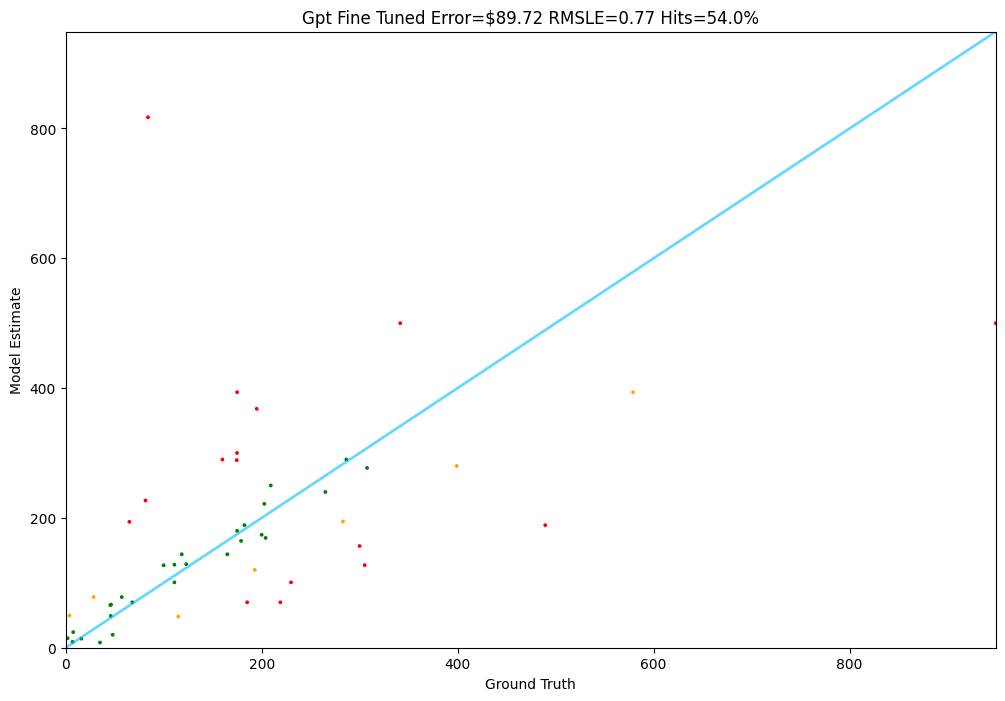

In [92]:
Tester(gpt_fine_tuned, data=test[:50], size=50).run()

### Summary:

1. **Data Limitations:** Due to the large dataset and high computational cost, only a subset of the data was utilized for this analysis.
2. **Fine-tuning Results:** Fine-tuning with Weights & Biases (W&B) resulted in some improvement in the results; however, further optimization with a larger dataset is necessary.
3. **Acknowledgement and Purpose:** We greatly acknowledge Ed Donner for providing instruction on this exercise, which is intended for practice purposes only.
